In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.stats import rankdata
import pickle

/home-2/jpopp4@jhu.edu/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


Load in the processed data

In [2]:
neur = sc.read_h5ad('../data/neur.h5ad')

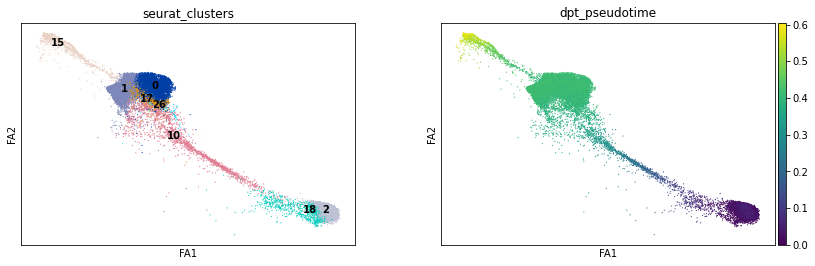

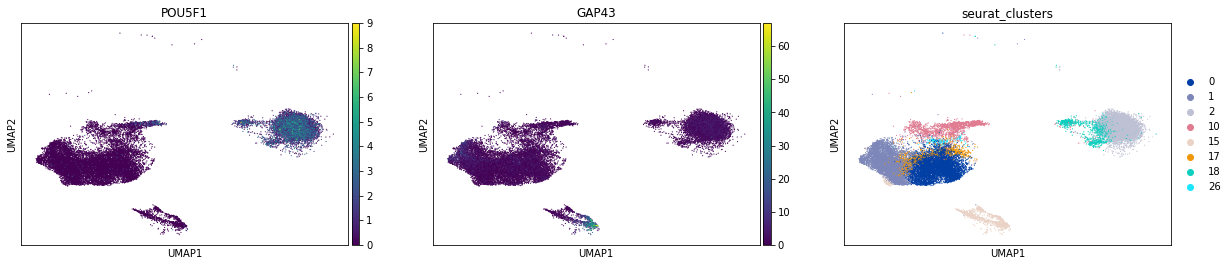

In [3]:
sc.pl.draw_graph(neur, color=['seurat_clusters', 'dpt_pseudotime'], legend_loc='on data')
sc.pl.umap(neur, color=['POU5F1', 'GAP43', 'seurat_clusters'])

Now to create pseudotime-based deciles.  For each sample I'll aggregate pseudobulk taking the sum of all expression, and then I'll create the matrices needed for splitGPM.  First, we can subset to the top 5000 highly variable features

Trying to set attribute `.obs` of view, copying.


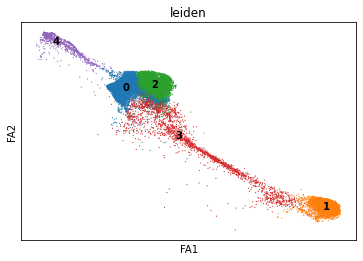

In [7]:
sc.tl.leiden(neur, resolution=0.25)
sc.pl.draw_graph(neur, color=['leiden'], legend_loc='on data')

In [8]:
neur = neur[:,neur.var['Selected']==1]

In [9]:
_, nG = neur.X.shape
nC = len(np.unique(neur.obs['leiden']))

In [27]:
counts = neur.X
t = np.zeros(nC)
Y = np.zeros([nC, nG])
for c in np.unique(neur.obs['leiden']):
    neur_c = neur[neur.obs['leiden'] == c]
    exp_c = csr_matrix.sum(neur_c.X, 0)
    Y[int(c),:] = exp_c
    t[int(c)] = np.median(neur[neur.obs['leiden'] == c].obs['dpt_pseudotime'])

Quantile normalize the data

In [8]:
def quantile_normalize(data):
    featranks = np.zeros(data.shape, dtype=int)
    normdata = np.zeros(data.shape)
    for i in range(len(featranks)):
        featranks[i,:] = rankdata(data[i,:])
    featranks -= 1
    normexp = np.average(np.sort(data, axis=1), axis=0)
    for i in range(data.shape[0]):
        for g in range(data.shape[1]):
            normdata[i,g] = normexp[featranks[i,g]]
    return(normdata)

In [12]:
Ynorm = quantile_normalize(Y)
Yflat = Y.flatten()

Now we can make sure that the patterns we expect to see are at least somewhat present by looking at canonical marker genes

In [14]:
genedict = {neur.var.index[i]:i for i in range(len(neur.var.index))}

Pluripotency marker POU5F1

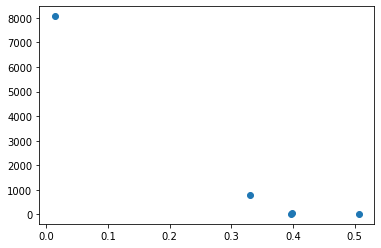

In [22]:
pl.plot(t, Y[:,genedict["POU5F1"]], "o")

Neuronal marker GAP43

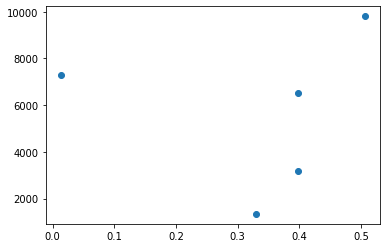

In [21]:
pl.plot(t, Y[:,genedict["GAP43"]], "o")

Try dividing each row of Y by the max before quantile normalization

In [28]:
Y2 = np.zeros(Y.shape)
for i in range(len(Y)):
    Y2[i,:] = Y[i,:]/max(Y[i,:])
Y2norm = quantile_normalize(Y2)

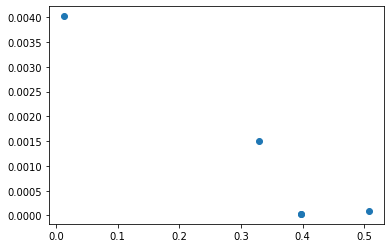

In [29]:
pl.plot(t, Y2[:,genedict["POU5F1"]], "o")

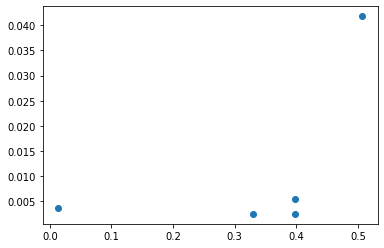

In [30]:
pl.plot(t, Y2[:,genedict["GAP43"]], "o")

This still isn't great, because the median pseudotime values are too close together, which is going to make it hard.  I'll try creating decile bins

In [5]:
_, nG = neur.X.shape
nC = 10
counts = neur.X
t = np.zeros(nC)
numcells = np.zeros(nC)
Y = np.zeros([nC, nG])
bin_w = max(neur.obs['dpt_pseudotime'])/nC
for c in range(nC):
    neur_c = neur[(c*bin_w <= neur.obs['dpt_pseudotime']) & (neur.obs['dpt_pseudotime'] < (c+1)*bin_w)]
    exp_c = csr_matrix.mean(neur_c.X, 0)
    numcells[c] = neur_c.shape[0]
    Y[int(c),:] = exp_c
    t[int(c)] = np.median(neur_c.obs['dpt_pseudotime'])

How many cells are there in each decile bin?

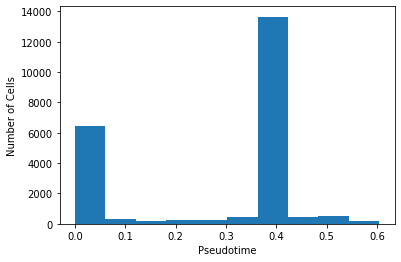

In [6]:
pl.hist(neur.obs['dpt_pseudotime'], bins=10)
pl.xlabel("Pseudotime")
pl.ylabel("Number of Cells")
pl.show()

In [7]:
Ynorm = quantile_normalize(Y)
Yflat = Y.flatten()

NameError: name 'quantile_normalize' is not defined

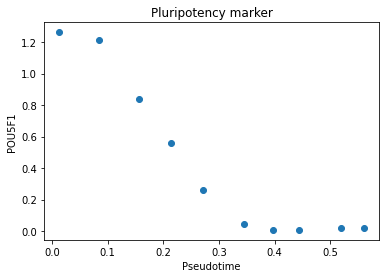

In [106]:
pl.plot(t, Y[:,genedict["POU5F1"]], "o")
pl.ylabel("POU5F1")
pl.xlabel("Pseudotime")
pl.title("Pluripotency marker")
pl.show()

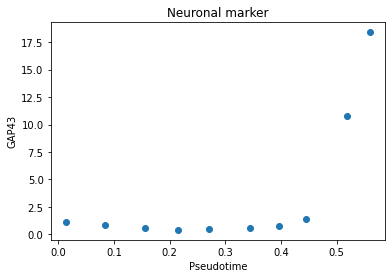

In [107]:
pl.plot(t, Y[:,genedict["GAP43"]], "o")
pl.ylabel("GAP43")
pl.xlabel("Pseudotime")
pl.title("Neuronal marker")
pl.show()

In [92]:
X = np.zeros([nC*nG,3])
for c in range(nC):
    X[c*nG:((c+1)*nG),0] = t[c]
    X[c*nG:((c+1)*nG),1] = c
    X[c*nG:((c+1)*nG),2] = list(range(nG))

Since this (as is) just assigns genes to clusters based on the order of magnitude of their expression, we need to make these comparable

In [93]:
np.savetxt( "../data/neur.X.txt", X)
Yflat = Y.flatten()
np.savetxt("../data/neur.Y.txt", Yflat)

In [99]:
with open("../data/genedict.pickle", 'wb') as f:
    pickle.dump(genedict, f)
    f.close()

NameError: name 'gen_gsea_df' is not defined